## Ejercicio 1

Asociación de Palabras

In [9]:
from xml.dom import minidom
xmldoc = minidom.parse('ap/ap.xml')
doclist = xmldoc.getElementsByTagName('DOC')

docs = {}
corpus_text = ''

for doc in doclist:
    docno = doc.getElementsByTagName('DOCNO')[0].firstChild.data.strip()
    text = doc.getElementsByTagName('TEXT')[0].firstChild.data.strip()
    docs[docno] = text
    corpus_text += text

KeyboardInterrupt: 

In [24]:
from nltk.corpus import wordnet as wn

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

In [25]:
import re

cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

caseInsCList = {}

for key, value in cList.items():
    caseInsCList[key.lower()] = value

c_re = re.compile('(%s)' % '|'.join(caseInsCList.keys()), re.IGNORECASE)

def expandContractions(text, c_re=c_re):
    def replace(match):
        return caseInsCList[match.group(0).lower()]
    return c_re.sub(replace, text)

In [3]:
import nltk
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords

from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

In [13]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/fede/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
def lemmatize_with_tag(word, tag):
    wordType = penn_to_wn(tag)
    if wordType is None:
        return None
    return wordnet_lemmatizer.lemmatize(word, pos=wordType)

vocabulary = {}
corpus_tokens = []
corpus_processed_tokens = []

for docno, text in docs.items():
    sents = sent_detector.tokenize(text)
    for sent in sents:
        sent = expandContractions(sent)
        tokens = tokenizer.tokenize(sent)
        corpus_tokens += tokens
        token_with_tags = nltk.pos_tag(tokens)
        for token_with_tag in token_with_tags:
            word = lemmatize_with_tag(token_with_tag[0], token_with_tag[1])
            if word is not None and word not in stopwords.words('english'):
                corpus_processed_tokens.append(word)
                if word in vocabulary:
                    vocabulary[word] += 1
                else:
                    vocabulary[word] = 1

NameError: name 'expandContractions' is not defined

In [167]:
print(len(vocabulary))

37118


In [1]:
import operator
sorted_vocabulary = sorted(vocabulary.items(), key=operator.itemgetter(1))
#print(sorted_vocabulary)

NameError: name 'vocabulary' is not defined

In [2]:
the500 = list(map(lambda x: x[0], sorted_vocabulary[-500:]))[::-1]
#print(the500)

NameError: name 'sorted_vocabulary' is not defined

In [1]:
from nltk.collocations import BigramCollocationFinder
bigram_measures = nltk.collocations.BigramAssocMeasures()

def getBestPairContaining(word, tokens):
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_ngram_filter(lambda w1, w2: word not in (w1, w2))
    return finder.nbest(bigram_measures.pmi, 1)[0]

NameError: name 'nltk' is not defined

In [189]:
for word in the500:
    print(word)
    print(getBestPairContaining(word, corpus_tokens))

say
('Demographers', 'say')
year
('hectic', 'year')
percent
('1.0', 'percent')
people
('1,008', 'people')
also
('Flames', 'also')
government
('Communist-dominated', 'government')
make
('_Quickly', 'make')
U.S.
('U.S.', 'warship')
official
('embezzeling', 'official')
report
('28-page', 'report')
last
('120.30', 'last')
go
('dared', 'go')
take
('breeze', 'take')
_
('1,205.75', '_')
state
('10,520', 'state')
time
('daylight-saving', 'time')
Bush
('Bush', 'affectionately')
include
('Exceptions', 'include')
new
('11,300', 'new')
get
('get', 'Zhelyu')
day
('155th', 'day')
first
('first', 'all-woman')
Soviet
('Soviet', 'Lunakod')
tell
('tell', 'ya')
week
('fitful', 'week')
New
('New', 'Delhi')
United
('United', 'Technologies')
company
('Disney-controlled', 'company')
use
('Condom', 'use')
call
('intimates', 'call')
work
('work', 'stoppage')
month
('90th', 'month')
country
('democratized', 'country')
give
('give', 'continuity')
come
('dares', 'come')
today
('1.7695', 'today')
plan
('cash-for-f

('exploitable', 'source')
union
('1.6-million-member', 'union')
never
('never', 'ceases')
appear
('Hannah', 'appear')
small
('circumnavigating', 'small')
prison
('22-year', 'prison')
employee
('employee', 'stock-ownership')
strike
('four-week', 'strike')
turn
('turn', 'soliders')
Co.
('Co.', 'Amplifying')
Committee
('Anti-Discrimination', 'Committee')
write
('write', 'Rosty')
reach
('reach', '200,000-250,000')
action
('action', 'adventures')
City
('Air-Conditioned', 'City')
chairman
('chairman', 'K.F')
involve
('involve', 'trimming')
less
('less', 'abrasive')
budget
("'91", 'budget')
estimate
('degradation', 'estimate')
aid
('15-billion', 'aid')
State
('Brushy', 'State')
June
('June', '10-17')
board
('Scrabble', 'board')
March
('Closes', 'March')
general
('four-star', 'general')
concern
('deep-seated', 'concern')
interview
('14-minute', 'interview')
committee
('ministerial', 'committee')
German
('1.5245', 'German')
buy
('buy', 'hard-to-get')
Japan
('Japan', 'Chambaer')
Ms.
('Ms.', 'Wol

In [190]:
for word in the500:
    print(word)
    print(getBestPairContaining(word, corpus_processed_tokens))

say
('Buth', 'say')
year
('1-to-10', 'year')
percent
('DK-NA', 'percent')
people
('Funerals', 'people')
also
('14-10', 'also')
government
('Bhutto', 'government')
make
("'80s", 'make')
U.S.
('1869-1951', 'U.S.')
official
('Baldus', 'official')
report
('28-page', 'report')
last
('Arcadia', 'last')
go
('Automakers', 'go')
take
('Castel', 'take')
_
('1981-86', '_')
state
('Moslem-majority', 'state')
time
('fainter', 'time')
Bush
('257-176', 'Bush')
include
('Assts', 'include')
new
('Cupid', 'new')
get
('12-1', 'get')
day
('million-share', 'day')
first
('Bridgeton', 'first')
Soviet
('Approval', 'Soviet')
tell
('Conti', 'tell')
week
('Briefs', 'week')
New
('Lauder', 'New')
United
('United', 'Technologies')
company
('Disney-controlled', 'company')
use
('Adamses', 'use')
call
('212-587-1111', 'call')
work
('Deidre', 'work')
month
('Antall', 'month')
country
('Centres', 'country')
give
('431-355', 'give')
come
('Condemnations', 'come')
today
('Civilians', 'today')
plan
('cash-for-food', 'plan'

('Tchibanga', 'small')
prison
('22-year', 'prison')
employee
('10-million-share', 'employee')
strike
('Sympathy', 'strike')
turn
('Ballots', 'turn')
Co.
('Co.', 'Amplifying')
Committee
('Anti-Discrimination', 'Committee')
write
('Barkett', 'write')
reach
('Campomanas', 'reach')
action
('Sylmar', 'action')
City
('City', 'Poros')
chairman
('Ayres', 'chairman')
involve
('SII', 'involve')
less
('Broadside', 'less')
budget
("'91", 'budget')
estimate
('Cap-Haitien', 'estimate')
aid
('15-billion', 'aid')
State
('Armacost', 'State')
June
('June', '16,100-foot')
board
('Bross', 'board')
March
('Closes', 'March')
general
('four-star', 'general')
concern
('1968', 'concern')
interview
('14-minute', 'interview')
committee
('40-man', 'committee')
German
('Budweis', 'German')
buy
('Dominguez', 'buy')
Japan
('Atsugi', 'Japan')
Ms.
('Drenkmann', 'Ms.')
file
('Gregorie', 'file')
recent
('APS', 'recent')
study
('NASA-funded', 'study')
Court
('Chancery', 'Court')
require
('Corridor', 'require')
refuse
('H

## Ejercicio 2

In [5]:
darwinFile = open('darwin.txt', 'r') 
darwinText = darwinFile.read()

In [6]:
import re, string
def remove_punctuation ( text ):
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

In [8]:
darwinTextNoPunctuation = remove_punctuation(darwinText)
darwinTokens = tokenizer.tokenize(darwinTextNoPunctuation)

In [9]:
#print(darwinTokens)

Duda1: al calcular los pares, se hace con el texto tokenizado o con el texto procesado ordenado

Duda2: como procesar antes de calcular las cosas en el ej2 (hacer todo el proceso o solo sacar puntuacion)

## Rate of Word Occurrence

item 2)

Definimos un tamaño de ventana T.

Elegimos una palabra W.

V(W) es el vector con 1 y 0 de las apariciones 

P(W, Pos) es 0 si la palabra no aparece en la Pos.
          es 1 * Gaussiana(Pos, Sigma)
          
Gaussiana(Pos, Sigma=50) = ...(paper)

Calcular P(W, Pos) y P(W, Pos + T)

Calcular C(W, T)

Variar el T y graficar en funcion de T.


## Entropia

Definimos P partes del texto. En el paper usa P = 64

item 3)

Definir entropia H(J | W) usando nj como la cantidad de apariciones de W en la particion j
                                y n como la cantidad de apariciones de W en todo el texto
Ver ecuacion (3) del paper.

item 4)

Entropia con texto random:

Calcular (C.3) usando como P la cantidad de capitulos y p(m) la definicion en (C.4)

Graficar la entropia en funcion de la frecuencia de las palabras en el texto


## Ejercicio 3

Comparación de word embeddings

Buscar como calcular LSA y Word2Vec de una palabra:
    LSA -> http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
    Word2Vec -> https://code.google.com/archive/p/word2vec/
   
Comparar resultados usando:

item1) WordSim3531 (se descarga y se compara la similaridad de 2 palabras)

item2) nltk wordnet similarity (modulo de python para calcular similaridad de 2 palabras)

In [10]:
darwinTextNoPunctuation = remove_punctuation(darwinText)
darwinTokens = tokenizer.tokenize(darwinTextNoPunctuation)

In [14]:
#print darwinTokens

In [11]:
from nltk import FreqDist
import numpy as np
from __future__ import division

def cuantas_apariciones_en_zona(zona, palabra):
    resultado = 0
    for z in zona : 
        if z == palabra : 
            resultado = resultado + 1
    return resultado

def dame_mayores_menores_frecuencias(lista_palabra_frecuencia, cantidad ):
    return []

def ejercicio_entropia(darwinTokens, palabras_mayores_frecuencias, palabras_menores_frecuencias):
    tamanio_partes = int(len(darwinTokens) / 64)
    capitulos = []
    for i in range(0, 64):
        capitulos.append(darwinTokens[i * tamanio_partes : i * tamanio_partes + tamanio_partes])
    
    entropias_mayores = []
    entropias_menores = []
    for p in palabras_mayores_frecuencias : 
        n_grande = cuantas_apariciones_en_zona(darwinTokens, p)
 
        sumatoria = 0
        for i in range(0,64):
            n_chica = cuantas_apariciones_en_zona(capitulos[i] , p)
            if not n_chica == 0 : 
                sumatoria = sumatoria + np.log2(n_chica / n_grande) * (n_chica / n_grande)
        entropias_mayores.append(-1*sumatoria)
    
 
    for p in palabras_menores_frecuencias : 
        n_grande = cuantas_apariciones_en_zona(darwinTokens, p)
        sumatoria = 0
        for i in range(0,64):
            n_chica = cuantas_apariciones_en_zona(capitulos[i] , p)
            if not n_chica == 0 : 
                sumatoria = sumatoria + np.log2(n_chica / n_grande) * (n_chica / n_grande)
        entropias_menores.append(-1*sumatoria)
    
    return entropias_mayores , entropias_menores     

In [12]:

darwinTokens = [word for word in darwinTokens if word not in stopwords.words('english')]

frecuencias = FreqDist(darwinTokens)
mas_frecuentes = []
menos_frecuentes = []

for word, frequency in frecuencias.most_common(50):
    mas_frecuentes.append(word)

menos_frecuentes = FreqDist(dict(frecuencias.most_common()[-50:]))
menos_frecuentes = list(menos_frecuentes.keys())


entropias_mayores , entropias_menores = ejercicio_entropia(darwinTokens, mas_frecuentes, menos_frecuentes)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  


In [14]:
frecuencias_graficar = map(lambda x : cuantas_apariciones_en_zona(darwinTokens, x), mas_frecuentes)
print frecuencias_graficar

[1510, 994, 629, 507, 487, 431, 424, 406, 400, 369, 343, 333, 327, 301, 295, 290, 285, 282, 269, 253, 252, 249, 248, 244, 243, 243, 234, 233, 230, 223, 223, 221, 219, 217, 217, 216, 204, 201, 199, 199, 197, 196, 195, 193, 191, 190, 187, 185, 183, 180]


In [15]:
from random import shuffle

darwinTextNoPunctuation = remove_punctuation(darwinText)
darwinTokens = tokenizer.tokenize(darwinTextNoPunctuation)

darwinTokens = [word for word in darwinTokens if word not in stopwords.words('english')]

shuffle(darwinTokens)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  


In [16]:
entropias_mayores_random , entropias_menores_random = ejercicio_entropia(darwinTokens, mas_frecuentes, menos_frecuentes)


In [18]:
import matplotlib.pyplot as plt

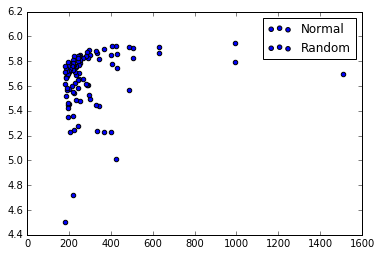

In [20]:
plt.figure()
plt.scatter(frecuencias_graficar , entropias_mayores , label = 'Normal', color = 'r')
plt.scatter(frecuencias_graficar , entropias_mayores_random , label = 'Random' , color = 'g' )
plt.legend(loc='best')
plt.show()